In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from cellpack_analysis.utilities.plotting_tools import save_PILR_image

/allen/aics/animated-cell/Saurabh/Softwares/miniconda3/envs/cellpack_analysis/lib/python3.9/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


Read in average PILR

In [ ]:
STRUCTURE_ID = "RAB5A"
EXPERIMENT = "RS"

In [21]:
base_folder = f"/allen/aics/animated-cell/Saurabh/cellpack-analysis/results/{STRUCTURE_ID}/{EXPERIMENT}/"

In [22]:
with open(f"{base_folder}/avg_PILR.json", "r") as f:
    avg_pilr = json.load(f)

In [23]:
for key in avg_pilr.keys():
    avg_pilr[key] = np.array(avg_pilr[key])

In [24]:
print(avg_pilr.keys())

dict_keys(['RAB5A', 'random', 'membrane_moderate', 'nucleus_moderate', 'membrane_moderate_invert', 'nucleus_moderate_invert', 'planar_gradient_Z'])


Channel name dictionary

In [25]:
ch_names_dict = {
    # "SLC25A17": "Peroxisome",
    "RAB5A": "Endosome",
    "random": "Random",
    # "membrane_weak_gradient": "Membrane Weak",
    "membrane_moderate": "Membrane Moderate",
    # "membrane_strong_gradient": "Membrane Strong",
    # "nucleus_weak_gradient": "Nucleus Weak",
    "nucleus_moderate": "Nucleus Moderate",
    # "nucleus_strong_gradient": "Nucleus Strong",
    # "membrane_weak_gradient_invert": "Membrane Weak inverted",
    "membrane_moderate_invert": "Membrane Moderate inverted",
    # "membrane_strong_gradient_invert": "Membrane Strong inverted",
    # "nucleus_weak_gradient_invert": "Nucleus Weak inverted",
    "nucleus_moderate_invert": "Nucleus Moderate inverted",
    # "nucleus_strong_gradient_invert": "Nucleus Strong inverted",
    "planar_gradient_Z": "Apical gradient",
}

In [26]:
ch_colors_dict = {
    key: f"C{i}"
    for i, key in enumerate(ch_names_dict.keys())
}

Set raw image channel

In [27]:
raw_image_channel = STRUCTURE_ID
raw_image_label = ch_names_dict[raw_image_channel]

In [35]:
raw_image_channel = None
raw_image_label = "Peroxisome"

### Save PILR images

In [28]:
for ch, pilr in avg_pilr.items():

    # if ch == raw_image_channel:
    #     vmin, vmax = np.percentile(pilr, [1, 90])
    # else:
    #     vmin, vmax = None, None

    save_PILR_image(
        pilr,
        ch_name=ch,
        save_dir=base_folder,
        # vmin=vmin,
        # vmax=vmax,
    )

### Plot radial profile

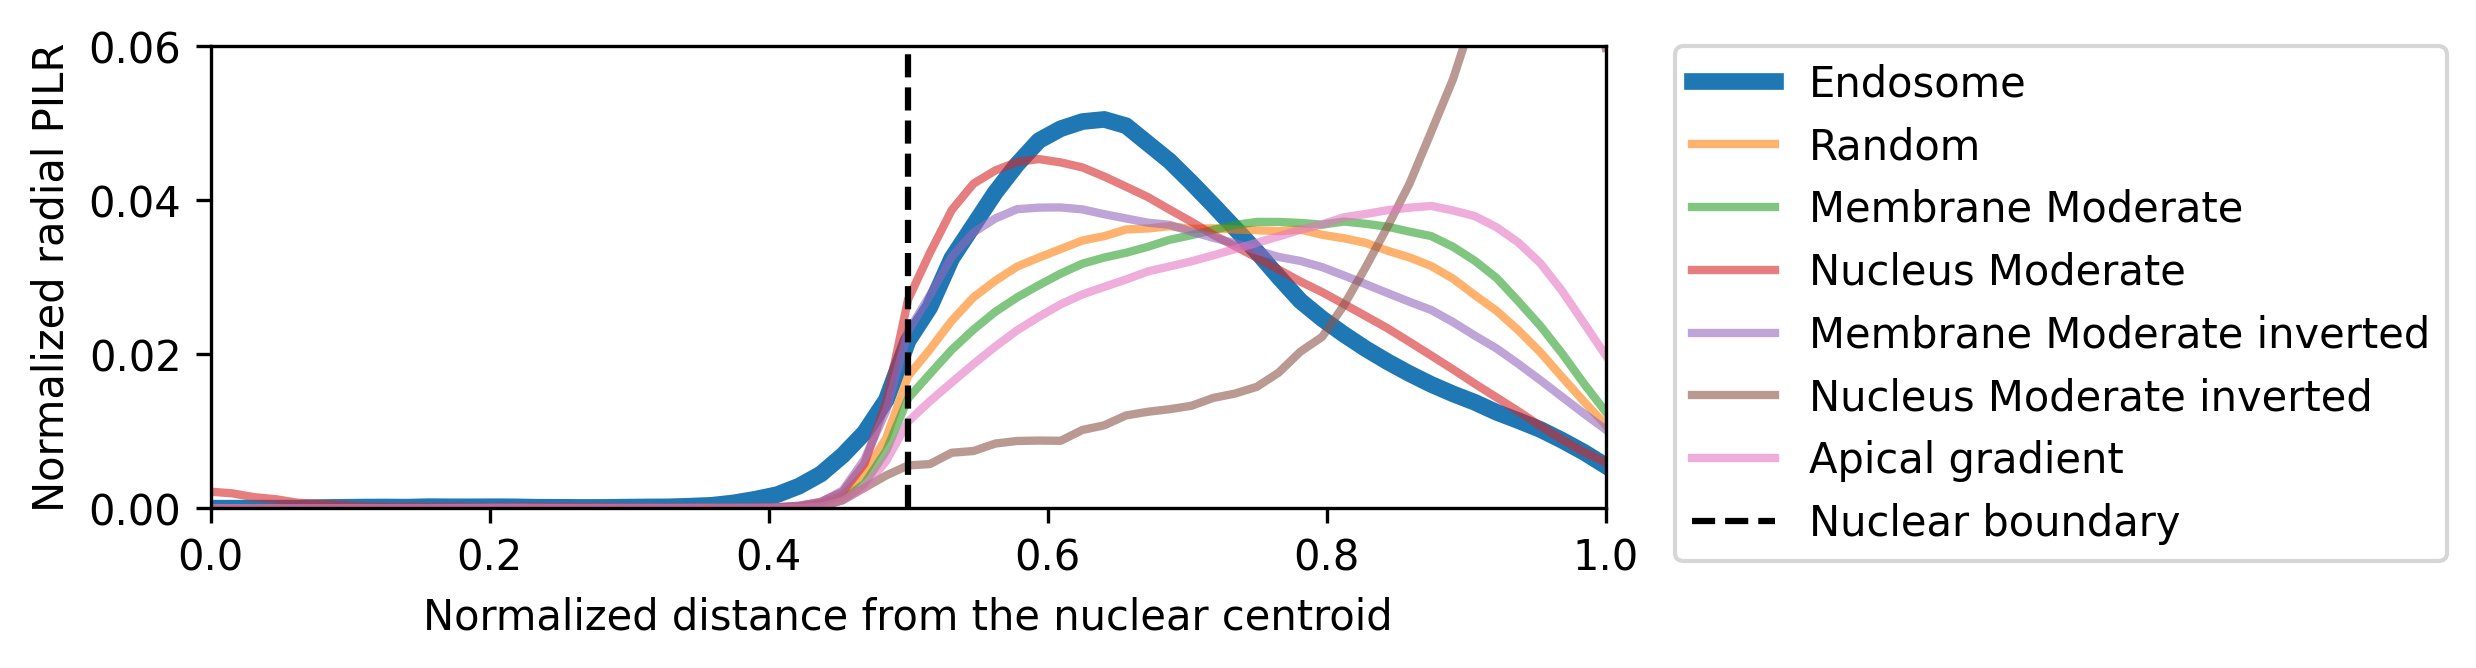

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2), dpi=300)
# for ch in avg_pilr:
# for ch in ["SLC25A17", "membrane", "random", "nucleus_square"]:
# for ch in [raw_image_channel, "nucleus_strong_gradient", "nucleus_strong_gradient_invert", "membrane_strong_gradient", "membrane_strong_gradient_invert"]:
for ch in ch_names_dict:
    if ch not in avg_pilr:
        continue
    pilr = avg_pilr[ch]
    pilrsum = np.sum(pilr, axis=1)
    pilrsum = pilrsum / np.sum(pilrsum)
    linewidth = 4 if ch == raw_image_channel else 2
    alpha = 1 if ch == raw_image_channel else 0.6
    ax.plot(np.linspace(0,1, len(pilrsum)), pilrsum, label=ch_names_dict[ch], linewidth=linewidth, alpha=alpha, color=ch_colors_dict[ch])

ax.axvline(0.5, ls="--", color="black", label="Nuclear boundary")
ax.set_xlabel("Normalized distance from the nuclear centroid")
ax.set_ylabel("Normalized radial PILR")
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xlim([0,1])   
ax.set_ylim([0,0.06]) 
# put legend on the right outside the axis
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# ax.legend()
fig.savefig(f"{base_folder}/avg_PILR_squeezed.png", dpi=300, bbox_inches="tight")


Get correlations between average PILRs

In [30]:
df = pd.DataFrame(
    index=ch_names_dict.values(), columns=ch_names_dict.values(), dtype=float
)
std_df = pd.DataFrame(
    index=ch_names_dict.values(), columns=ch_names_dict.values(), dtype=float
)

### Calculate correlations between channels

In [31]:
from cellpack_analysis.utilities.PILR_tools import get_processed_PILR_from_dict

In [32]:
mask_nucleus = True
average_over_phi = False

for ch_ind, ch_name in ch_names_dict.items():
    if ch_ind not in avg_pilr:
        continue
    pilr1, std_pilr1 = get_processed_PILR_from_dict(avg_pilr, ch_ind, average_over_phi=average_over_phi, mask_nucleus=mask_nucleus)

    for ch_ind2, ch_name2 in ch_names_dict.items():
        if ch_ind2 not in avg_pilr:
            continue
        pilr2, std_pilr2 = get_processed_PILR_from_dict(avg_pilr, ch_ind2, average_over_phi=average_over_phi, mask_nucleus=mask_nucleus)

        corrcoef = np.corrcoef(
            pilr1, pilr2
        )[0, 1]
        df.loc[ch_name, ch_name2] = corrcoef
        std_df.loc[ch_name, ch_name2] = np.sqrt((1 - corrcoef ** 2) / (len(pilr1) - 2)) * std_pilr1 * std_pilr2


In [33]:
df = df.sort_values(by=raw_image_label, ascending=False).sort_values(by=raw_image_label, axis=1, ascending=False)

In [34]:
df

,Endosome,Nucleus Moderate,Random,Membrane Moderate,Membrane Moderate inverted,Nucleus Moderate inverted,Apical gradient
Endosome,1.000000,0.336144,0.117702,0.089667,0.019891,-0.081598,-0.109385
Nucleus Moderate,0.336144,1.000000,0.190910,0.086995,0.207533,-0.266254,0.112526
Random,0.117702,0.190910,1.000000,0.142718,0.159184,-0.056326,0.074482
Membrane Moderate,0.089667,0.086995,0.142718,1.000000,-0.099189,0.004239,0.224036
Membrane Moderate inverted,0.019891,0.207533,0.159184,-0.099189,1.000000,-0.151629,-0.362951
Nucleus Moderate inverted,-0.081598,-0.266254,-0.056326,0.004239,-0.151629,1.000000,-0.095606
Apical gradient,-0.109385,0.112526,0.074482,0.224036,-0.362951,-0.095606,1.000000


: 

In [19]:
bar_vals = df.loc[raw_image_label, [col for col in df.columns if col != raw_image_label]].values
bar_errs = std_df.loc[raw_image_label, [col for col in df.columns if col != raw_image_label]].values

Create bar plot with values and errors

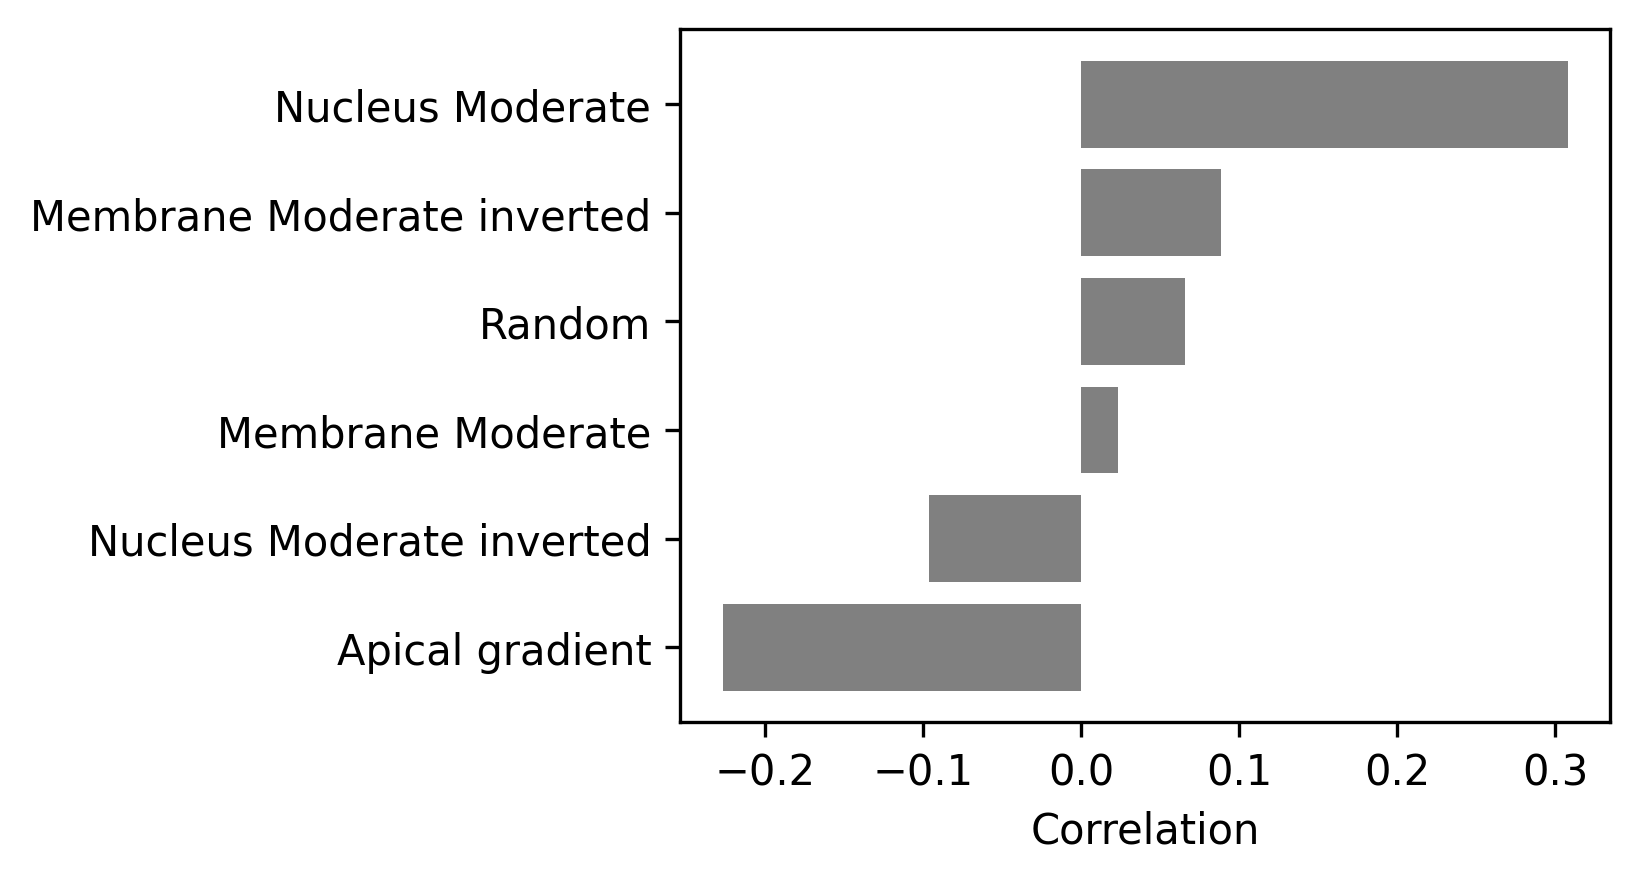

In [20]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
y_pos = np.arange(len(bar_vals))

ax.barh(
    y_pos,
    bar_vals,
    xerr=bar_errs,
    color="gray",
) 
ax.set_yticks(y_pos, labels = [col for col in df.columns if col != raw_image_label])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Correlation")
# ax.set_xlim([-0.3, 0.3])
plt.show()


### Create heatmap

In [67]:
import seaborn as sns

In [68]:
df_sorted = df.sort_values(by=raw_image_label, ascending=False).sort_values(by=raw_image_label, axis=1, ascending=False)

In [69]:
df_sorted

,Endosome,Nucleus Moderate,Random,Membrane Moderate,Membrane Moderate inverted,Nucleus Moderate inverted,Apical gradient
Endosome,1.000000,0.319275,0.115549,0.096020,0.045900,-0.028009,-0.106703
Nucleus Moderate,0.319275,1.000000,0.192900,0.084328,0.217968,-0.298144,0.115711
Random,0.115549,0.192900,1.000000,0.103989,0.160302,-0.107826,0.067463
Membrane Moderate,0.096020,0.084328,0.103989,1.000000,-0.105954,-0.018709,0.216915
Membrane Moderate inverted,0.045900,0.217968,0.160302,-0.105954,1.000000,-0.199044,-0.375581
Nucleus Moderate inverted,-0.028009,-0.298144,-0.107826,-0.018709,-0.199044,1.000000,-0.128355
Apical gradient,-0.106703,0.115711,0.067463,0.216915,-0.375581,-0.128355,1.000000


In [ ]:
save_dir = "/allen/aics/animated-cell/Saurabh/cellpack-analysis/results/SLC25A17/sample_8d_actual_shape"

<Axes: >

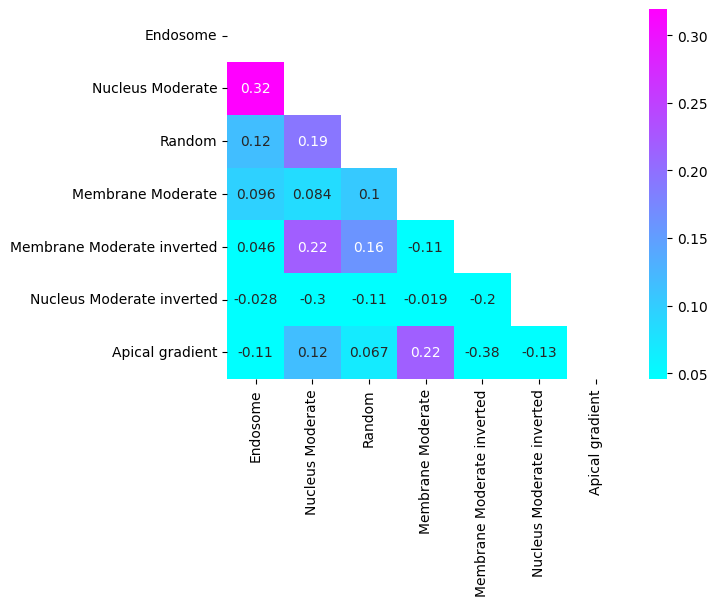

In [70]:
mask = np.zeros_like(df, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.close("all")
pex_vals = df.loc[raw_image_label].values
min_val = np.min(pex_vals[pex_vals > 0])
max_val = np.max(pex_vals[pex_vals < 0.9])
sns.heatmap(
    df,
    annot=True,
    cmap="cool",
    vmin=min_val,
    vmax=max_val,
    mask=mask,
)
# plt.savefig(
#     f"{save_dir}/PILR_correlation_bias_avg_phi.png",
#     dpi=300,
#     bbox_inches="tight",
# )

### Plot different gradients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def normalize_values(values):
    return (values - np.min(values)) / (np.max(values) - np.min(values))

In [ ]:
xvals = np.linspace(0.001,1,1000)
weak_vals = normalize_values(np.exp(-xvals / 0.9)) # (1 - xvals)
mod_vals = normalize_values(np.exp(-xvals / 0.3)) # (1 - xvals) ** 3
str_vals = normalize_values(np.exp(-xvals / 0.1)) # (1 - xvals) ** 8

fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=300)
ax.plot(xvals, weak_vals, label="Weak", linewidth=4, c="C3")
ax.plot(xvals, mod_vals, label="Moderate", linewidth=4, c="C4")
ax.plot(xvals, str_vals, label="Strong", linewidth=4, c="C5")
ax.legend(fontsize=18)
ax.set_yticks([])
ax.set_xticks([0, 1])
ax.set_xticklabels(["nucleus", "cell membrane"], fontsize=18)
ax.set_ylabel("Relative probability", fontsize=18)
plt.show()

Plot average PILR

In [75]:
pilr_vals = avg_pilr["planar_gradient_Z"]

In [73]:
from cellpack_analysis.utilities.plotting_tools import save_PILR_image

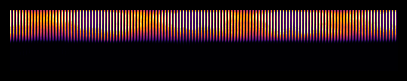

In [79]:
fig, ax = save_PILR_image(
    pilr_vals, ch_name=None, save_dir=None, suffix="", aspect=20, vmin=0, max_pct=90,
)
fig.show()